In [ ]:
import tensorflow as tf
print(tf.__version__)

# CARGA DE DATOS || OJO VENTANAS..

In [9]:
def crear_ventana_nuevo_lags_dft(
    dataset,
    ventana_entrada,
    ventana_salida,
    feature_cols=None,
    time_col="Time",
    mode="mark",                # "skip" | "mark" | "allow"
    allowed_gap_seconds=3700
):
    """
    Igual a crear_ventana_nuevo_lags, pero agrega las primeras 3 componentes DFT
    de la feature 0 (serie principal), replicadas por timestep, SOLO en mode="mark".
    """
    df = dataset.copy().reset_index(drop=True)

    if time_col in df.columns:
        df[time_col] = pd.to_datetime(df[time_col])
    else:
        df[time_col] = pd.to_datetime(df.index)

    if feature_cols is None:
        feature_cols = [c for c in df.columns if c != time_col]

    if "P1" not in df.columns:
        raise ValueError("DataFrame must contain 'P1' column as target.")

    total_len = len(df)
    total_muestras = total_len - ventana_entrada - ventana_salida + 1
    if total_muestras <= 0:
        return (
            np.empty((0, ventana_entrada, len(feature_cols))),
            np.empty((0, ventana_salida))
        )

    X_list = []
    y_list = []
    kept_indices = []

    times = df[time_col].values
    P1 = df["P1"].values
    features_all = df[feature_cols].values

    # columnas para evaluar horas y días
    idx_h0 = feature_cols.index("h_0")
    idx_h23 = feature_cols.index("h_23")

    dias_cols = ["lunes","martes","miercoles","jueves","viernes","sabado","domingo"]
    idx_day0 = feature_cols.index("lunes")
    idx_day6 = feature_cols.index("domingo")

    for i in range(total_muestras):
        if i == 0:
            print("MODE =", mode)

        start = i
        end = i + ventana_entrada

        window_times = pd.to_datetime(times[start:end])
        window_feats = features_all[start:end, :]

        # cruce de día
        window_times_np = window_times.to_numpy().astype("datetime64[ns]")
        unique_dates = np.unique(window_times_np.astype("datetime64[D]"))
        cruza_dia = (len(unique_dates) > 1)

        # EXTRAER horas/días desde one-hot
        hours = np.argmax(window_feats[:, idx_h0:idx_h23+1], axis=1)
        days = np.argmax(window_feats[:, idx_day0:idx_day6+1], axis=1)

        missing_hour_flag = False
        wrong_day_flag = False

        for t in range(len(hours)-1):
            h_now = hours[t]
            h_next = hours[t+1]
            if h_next != (h_now + 1) % 24:
                missing_hour_flag = True

            if h_now == 23:
                expected_day = (days[t] + 1) % 7
                if days[t+1] != expected_day:
                    wrong_day_flag = True

        ventana_incompleta = int(
            missing_hour_flag or
            wrong_day_flag or
            np.isnan(window_feats).any()
        )

        if mode == "skip" and cruza_dia:
            continue

        # ================
        # FEATURES NORMALES
        # ================
        if mode == "mark":
            col_cruza = np.full((ventana_entrada, 1), int(cruza_dia))
            col_inc = np.full((ventana_entrada, 1), ventana_incompleta)
            window_feats_aug = np.hstack([window_feats, col_cruza, col_inc])
        else:
            col_inc = np.full((ventana_entrada, 1), ventana_incompleta)
            window_feats_aug = np.hstack([window_feats, col_inc])

        # ============================
        # AGREGAR DFT SOLO EN "mark"
        # ============================
        if mode == "mark":

            # señal = primera columna de features en la ventana
            signal = window_feats[:, 0]

            # DFT completa
            dft_vals = np.fft.fft(signal)

            # tomamos magnitudes de las primeras 3 componentes
            dft_k = np.abs(dft_vals[:6])  # shape (3,)

            # replicamos para todos los timesteps
            dft_rep = np.tile(dft_k, (ventana_entrada, 1))  # shape (ventana_entrada, 3)

            # concatenamos al final de los features
            window_feats_aug = np.hstack([window_feats_aug, dft_rep])

        # target
        y_window = P1[end:end + ventana_salida]
        if len(y_window) != ventana_salida:
            continue

        X_list.append(window_feats_aug)
        y_list.append(y_window)
        kept_indices.append(i)

    if len(X_list) == 0:
        return (
            np.empty((0, ventana_entrada, window_feats_aug.shape[1])),
            np.empty((0, ventana_salida))
        )

    X = np.stack(X_list)
    y = np.stack(y_list)

    return X, y, kept_indices








def cargar_datos_especificos_nuevo2_semanal(
    archivo_potencias='potencia2.csv',
    dias_semanales=None,
    horas=None,
    ventana_entrada=24
):
    try:
        import pandas as pd
        import numpy as np
        import logging

        # --- Leer CSV ---
        df = pd.read_csv('potencia2.csv', sep=",")

        # --- Convertir tiempo ---
        df['Time'] = pd.to_datetime(df['Time'], unit='ms')
        df['Time'] = df['Time'].dt.tz_localize('UTC')
        df['Time'] = df['Time'].dt.tz_convert('Etc/GMT+3')
        df['Time'] = df['Time'].dt.tz_localize(None)

        # --- Promediar por hora ---
        df = (
            df.groupby(df['Time'].dt.floor('h'))['P1']
            .mean()
            .reset_index()
        )
        df['Time'] = df['Time'].dt.floor('h')

        # >>>>> NO se elimina ningún día <<<<<

        # --- Filtrar por días / horas opcionales ---
        if dias_semanales is not None:
            df = df[df['Time'].dt.dayofweek.isin(dias_semanales)]
        if horas is not None:
            df = df[df['Time'].dt.hour.isin(horas)]

        # --- Eliminar rangos "malos" que vos definiste manualmente ---
        rangos_a_eliminar = [
            ("2022-07-18", "2022-07-29"),
            ("2023-01-01", "2023-02-28"),
            ("2023-07-17", "2023-07-28"),
            ("2024-07-15", "2024-07-26"),
            ("2024-01-01", "2024-02-29"),
            ("2025-07-21", "2025-08-01"),
            ("2025-01-01", "2025-02-28")
        ]
        rangos_a_eliminar = []
        for ini, fin in rangos_a_eliminar:
            df = df.drop(df.loc[ini:fin].index)

        df.reset_index(drop=True, inplace=True)

        # ===============================
        #     FEATURES TEMPORALES
        # ===============================
        df['tiempo_del_dia'] = df['Time'].dt.hour + df['Time'].dt.minute/60
        df['dia_sen'] = np.sin(2*np.pi*df['tiempo_del_dia']/24)
        df['dia_cos'] = np.cos(2*np.pi*df['tiempo_del_dia']/24)

        df['dow'] = df['Time'].dt.weekday
        df['mes_sen'] = np.sin(2*np.pi*df['dow']/7)
        df['mes_cos'] = np.cos(2*np.pi*df['dow']/7)

        df['diferencia_activa'] = df['P1'].diff()
        df['pico'] = (df['diferencia_activa'].abs() > PICO_CONSIDERABLE).astype(int)
        df = df.dropna().copy()

        # --- Dummies día ---
        for i, dia in enumerate(['lunes','martes','miercoles','jueves','viernes','sabado','domingo']):
            df[dia] = (df['Time'].dt.dayofweek == i).astype(int)

        df['dia_habil'] = (df['Time'].dt.dayofweek < 5).astype(int)


        # =====================================================
        #      DÍA HÁBIL POR UMBRAL DE POTENCIA
        # =====================================================

        VALOR_UMBRAL = UMBRAL_CONSIDERACION_DIA

        # Antes de setear el índice, usá la columna Time para obtener la fecha
        df["fecha"] = df["Time"].dt.date

        # Potencia máxima por día
        max_por_dia = df.groupby("fecha")["P1"].max()

        # Día hábil = (lunes-viernes) y (potencia máxima del día > umbral)
        df["dia_habil"] = 0
        for fecha, maxval in max_por_dia.items():
            if maxval > VALOR_UMBRAL:
                dow = pd.Timestamp(fecha).dayofweek
                if dow < 5:  # 0-4 → lunes a viernes
                    df.loc[df["fecha"] == fecha, "dia_habil"] = 1

        # Eliminar columna auxiliar
        df.drop(columns=["fecha"], inplace=True)

        # ===============================
        #   FEATURE CLAVE: "dia_incompleto"
        #   Marca las primeras N filas que NO tienen ventana completa
        # ===============================
        df["dia_incompleto"] = 0
        df.loc[:ventana_entrada - 1, "dia_incompleto"] = 1



        # ============================================
        #     FEATURE: is_transition (7–9 o 13–17)
        # ============================================

        df["is_transition"] = 0  # default

        # Horas que cuentan como transición
        mask_hora = (
            ((df["Time"].dt.hour >= 7) & (df["Time"].dt.hour <= 9)) |
            ((df["Time"].dt.hour >= 13) & (df["Time"].dt.hour <= 17))
        )

        # Solo día hábil
        df.loc[mask_hora & (df["dia_habil"] == 1), "is_transition"] = 1


        # --- One hot de horas (0 a 23) ---
        df["hora"] = df["Time"].dt.hour.astype(int)
        df = pd.get_dummies(df, columns=["hora"], prefix="h", drop_first=False, dtype=int)

        cols_horas = [c for c in df.columns if c.startswith("h_")]




        # ============================================
        #           LAGS IMPORTANTES
        # ============================================
        df["lag1"] = df["P1"].shift(1)
        df["lag2"] = df["P1"].shift(2)
        df["lag3"] = df["P1"].shift(3)
        df["lag4"] = df["P1"].shift(4)
        df["lag5"] = df["P1"].shift(5)
        df["lag6"] = df["P1"].shift(6)
        df["lag24"] = df["P1"].shift(24)
        df["lag48"] = df["P1"].shift(48)

        # ============================================
        #           DELTAS (velocidad)
        # ============================================
        df["delta1"] = df["P1"] - df["lag1"]
        df["delta2"] = df["P1"] - df["lag2"]
        df["delta3"] = df["P1"] - df["lag3"]
        df["delta4"] = df["P1"] - df["lag4"]
        df["delta5"] = df["P1"] - df["lag5"]
        df["delta6"] = df["P1"] - df["lag6"]
        df["delta24"] = df["P1"] - df["lag24"]
        df["delta48"] = df["P1"] - df["lag48"]

        

        # limpiar NA generados por rollings y shifts
        df = df.dropna().copy()

        # ============================================
        #    ROLLING MEAN (tendencias locales)
        # ============================================
        df["roll_mean_3"] = df["P1"].rolling(3).mean()
        df["roll_mean_6"] = df["P1"].rolling(6).mean()
        df["roll_mean_24"] = df["P1"].rolling(24).mean()

        # ============================================
        #    ROLLING STD (volatilidad local)
        # ============================================
        df["roll_std_3"] = df["P1"].rolling(3).std()
        df["roll_std_6"] = df["P1"].rolling(6).std()
        df["roll_std_24"] = df["P1"].rolling(24).std()
        df = df.dropna().copy()
        # ===============================
        #   DataFrame final
        # ===============================
        #final_df = df[['P1','dia_sen','dia_cos','mes_sen','mes_cos','pico',

        final_df = df[['P1','dia_sen','dia_cos','mes_sen','mes_cos','pico',
                       'lunes','martes','miercoles','jueves','viernes','sabado','domingo',
                       'dia_habil','dia_incompleto','Time']
                       + ['lag1','lag2','lag3','lag24']
                       + ['delta1','delta2','delta3','delta24']
                       
                       
                       
                       + cols_horas]

        final_df.set_index('Time', inplace=True)

        return final_df

    except Exception as e:
        logging.error(f"Error al cargar los datos: {e}")
        raise



# MAIN Y VARIABLES

In [27]:

from red_principal import *  # para usar y guardar
from sklearn.preprocessing import StandardScaler

COMENTARIO = "base 2lstm con ciclico y hubber"
BATCH_SIZE = 16
EPOCAS = 300
PACIENCIA_EARLY = 10

PICO_CONSIDERABLE = 3
UMBRAL_CONSIDERACION_DIA = 13
MEZCLA_TRAIN = 0


ventana_entrada = 24
mediciones_previas = 1
ventana_salida = 1

if __name__ == "__main__":

    # Procesamiento de los datos
    #dias = [0,1,2,3,4,5,6]  # 0 luneS CON LA ULTIMA MOD
    dias = [0,1,2,3,4,5,6]

    horas = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]  # Ejemplo de horas

    df = cargar_datos_especificos_nuevo2_semanal('potencia.csv', dias_semanales=dias, horas=horas)
    df = df.drop(df.loc["2022-12-7":"2023-3-12"].index)
    df = df.drop(df.loc["2023-12-7":"2024-3-12"].index)
    df = df.drop(df.loc["2024-12-7":"2025-3-12"].index)
    #df = df.drop(df.loc["2022-2-7":"2024-2-20"].index)

    
    print("tengo estos datos ",df.shape)


    X, y, kept_indices = crear_ventana_nuevo_lags_dft(df, ventana_entrada, ventana_salida)

    kept_indices = np.array(kept_indices)

    print("crear ventana generó ", X.shape)

    # --- DEFINICIÓN DE LOS LÍMITES SOBRE EL DF (IGUAL QUE ANTES) ---
    inicio_train = 0
    fin_train = 10000

    FECHA_INICIO_TRAIN = df.index[inicio_train]
    FECHA_FIN_TRAIN    = df.index[fin_train]

    inicio_val = fin_train + 1
    fin_val    = fin_train + 1 + 2500#9000#2000

    FECHA_INICIO_VAL = df.index[inicio_val]
    FECHA_FIN_VAL    = df.index[fin_val]

    inicio_test = fin_val + 1 #2200
    fin_test = min(inicio_test + 1 + 2500, len(df)-1)

    FECHA_INICIO_TEST = df.index[inicio_test]
    FECHA_FIN_TEST    = df.index[fin_test]


    # --- CONVERSIÓN: índices del DF → índices dentro de X/Y ---
    mask_train = (kept_indices >= inicio_train) & (kept_indices <= fin_train)
    mask_val   = (kept_indices >= inicio_val)   & (kept_indices <= fin_val)
    mask_test  = (kept_indices >= inicio_test)  & (kept_indices <= fin_test)

    train_idx = np.where(mask_train)[0]
    val_idx   = np.where(mask_val)[0]
    test_idx  = np.where(mask_test)[0]


    # --- SPLITS FINALES ---
    Xtrain = X[train_idx]
    ytrain = y[train_idx]

    Xval = X[val_idx]
    yval = y[val_idx]

    Xtest = X[test_idx]
    ytest = y[test_idx]

    print("Xtrain:", Xtrain.shape)
    print("Xval:",   Xval.shape)
    print("Xtest:",  Xtest.shape)


    # Ejemplo: ytest es una columna o un DataFrame de una sola columna
    # Calculamos la diferencia con el valor anterior
    diferencias = np.abs(np.diff(ytest, axis=0))  # axis=0 → diferencias fila a fila

    # Contar cuántas diferencias superan PICO_CONSIDERABLE
    cantidad_picos = np.sum(diferencias > PICO_CONSIDERABLE)

    print("Cantidad de picos en ytest:", cantidad_picos)


    from sklearn.utils import shuffle

    # Mezclar Xtrain y ytrain
    if MEZCLA_TRAIN == 1:
        Xtrain, ytrain = shuffle(Xtrain, ytrain, random_state=42)


    # ============================
    #   SCALER ÚNICO PARA INPUTS
    # ============================
    input_scaler = StandardScaler()

    nsamples, ntimesteps, nfeatures = Xtrain.shape

    # Reestructuro para escalar feature por feature
    Xtrain_2d = Xtrain.reshape(-1, nfeatures)
    Xval_2d   = Xval.reshape(-1, nfeatures)
    Xtest_2d  = Xtest.reshape(-1, nfeatures)

    # Ajusto scaler SOLO con train
    input_scaler.fit(Xtrain_2d)

    # Transformo todo
    Xtrain_n_2d = input_scaler.transform(Xtrain_2d)
    Xval_n_2d   = input_scaler.transform(Xval_2d)
    Xtest_n_2d  = input_scaler.transform(Xtest_2d)

    # Regreso a 3D
    Xtrain_n = Xtrain_n_2d.reshape(nsamples, ntimesteps, nfeatures)
    Xval_n   = Xval_n_2d.reshape(Xval.shape)
    Xtest_n  = Xtest_n_2d.reshape(Xtest.shape)

    # ============================
    #     SCALER PARA Y
    # ============================
    target_scaler = StandardScaler()

    ytrain_n = target_scaler.fit_transform(ytrain)
    yval_n   = target_scaler.transform(yval)
    ytest_n  = target_scaler.transform(ytest)

    # guardo scalers
    scalers = {
        'input_scaler': input_scaler,
        'target_scaler': target_scaler
    }

tengo estos datos  (16682, 47)
MODE = mark
crear ventana generó  (16658, 24, 55)
Xtrain: (10001, 24, 55)
Xval: (2501, 24, 55)
Xtest: (2502, 24, 55)
Cantidad de picos en ytest: 252


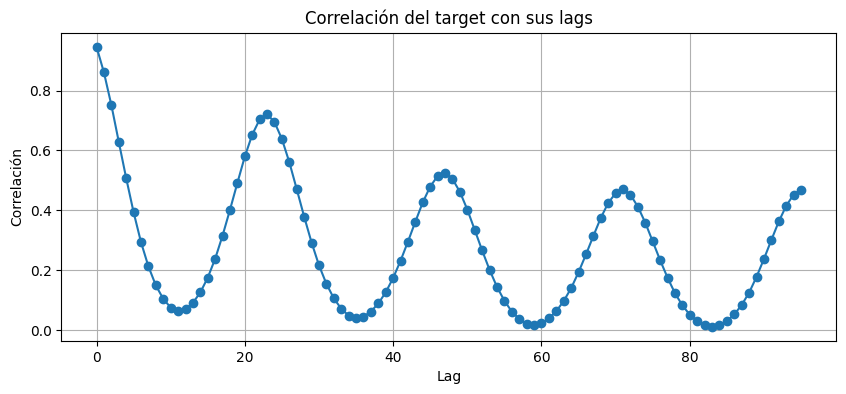

In [19]:
x = df["P1"].values
import numpy as np

def lag_corr(x, max_lag=96):
    corrs = []
    for lag in range(1, max_lag+1):
        corrs.append(np.corrcoef(x[lag:], x[:-lag])[0,1])
    return np.array(corrs)

corrs = lag_corr(x, 96)

plt.figure(figsize=(10,4))
plt.plot(corrs, marker='o')
plt.title("Correlación del target con sus lags")
plt.xlabel("Lag")
plt.ylabel("Correlación")
plt.grid(True)
plt.show()




In [13]:
import pandas as pd
import numpy as np

dias = ["lunes","martes","miercoles","jueves","viernes","sabado","domingo"]

dfs_filtrados = []

for dia in dias:
    df_dia = df[df[dia] == 1].copy()
    
    # Agrupamos por fecha completa (solo año-mes-día)
    df_dia['fecha'] = df_dia.index.date
    
    # Contamos cuántas horas hay por día
    conteo_por_fecha = df_dia.groupby('fecha').size()
    
    # Solo tomamos fechas que tengan 24 registros
    fechas_completas = conteo_por_fecha[conteo_por_fecha == 24].index
    
    # Filtramos el DataFrame
    df_dia = df_dia[df_dia['fecha'].isin(fechas_completas)]
    
    dfs_filtrados.append(df_dia)

# Concatenamos todos los días
df_filtrado = pd.concat(dfs_filtrados).sort_index()

# Calculamos el mínimo número de días completos entre todos los días
min_dias = min(df_filtrado[dia].groupby(df_filtrado.index.date).sum().shape[0] for dia in dias)

# Ahora recortamos al azar cada día para que tenga el mismo número de días completos
dfs_balanceados = []
for dia in dias:
    df_dia = df_filtrado[df_filtrado[dia] == 1].copy()
    fechas_unicas = df_dia.index.date
    fechas_unicas = sorted(list(set(fechas_unicas)))
    
    if len(fechas_unicas) > min_dias:
        # Elegimos al azar min_dias fechas
        fechas_seleccionadas = np.random.choice(fechas_unicas, min_dias, replace=False)
        df_dia = df_dia[df_dia['fecha'].isin(fechas_seleccionadas)]
    
    dfs_balanceados.append(df_dia)

# Concatenamos el dataset final balanceado
df_final = pd.concat(dfs_balanceados).sort_index()
df_final = df_final.drop(columns=['fecha'])

# Conteo final por día
conteo_final = {dia: df_final[dia].sum() for dia in dias}
print(conteo_final)


{'lunes': 3096, 'martes': 3264, 'miercoles': 3312, 'jueves': 3216, 'viernes': 3168, 'sabado': 3264, 'domingo': 3168}


In [89]:
import pandas as pd
import numpy as np

dias = ["lunes","martes","miercoles","jueves","viernes","sabado","domingo"]

# Cantidad objetivo de registros por día
objetivo = 1848

dfs_balanceados = []

for dia in dias:
    df_dia = df[df[dia] == 1].copy()
    
    # Agregar columna auxiliar para fecha completa
    df_dia['fecha'] = df_dia.index.date
    
    # Filtramos solo días completos de 24 horas
    conteo_por_fecha = df_dia.groupby('fecha').size()
    fechas_completas = conteo_por_fecha[conteo_por_fecha == 24].index
    df_dia = df_dia[df_dia['fecha'].isin(fechas_completas)]
    
    # Si hay más filas que el objetivo, eliminamos al azar
    if len(df_dia) > objetivo:
        df_dia = df_dia.sample(n=objetivo, random_state=42)  # random_state para reproducibilidad
    
    dfs_balanceados.append(df_dia)

# Concatenamos todos los días balanceados
df_final = pd.concat(dfs_balanceados).sort_index()

# Eliminamos columna auxiliar
df_final = df_final.drop(columns=['fecha'])

# Conteo final por día
conteo_final = {dia: df_final[dia].sum() for dia in dias}
print(conteo_final)


{'lunes': 1848, 'martes': 1848, 'miercoles': 1848, 'jueves': 1848, 'viernes': 1848, 'sabado': 1848, 'domingo': 1848}


In [92]:
COMENTARIO = "version lags (menos lags) con pico (el ant tambien)"

In [ ]:
    X, y = crear_ventana_nuevo_lags(df_final, ventana_entrada, ventana_salida)

    print("crear ventana genero ",X.shape)
   
    ####### SEPARACION DE DATOS
    inicio_train = 0#3
    fin_train = 9000 #6500
    FECHA_INICIO_TRAIN = df.index[inicio_train]
    FECHA_FIN_TRAIN = df.index[fin_train]
    
    
    #fin_train = 500

    inicio_val = fin_train+1
    #fin_val = fin_train+1+100
    fin_val = fin_train+1+2000#1250
    FECHA_INICIO_VAL = df.index[inicio_val]
    FECHA_FIN_VAL = df.index[fin_val]

    inicio_test = fin_val+1
    #fin_test = inicio_test+1+100
    fin_test = inicio_test+1+2200#1250
    FECHA_INICIO_TEST = df.index[inicio_test]
    FECHA_FIN_TEST = df.index[fin_test]


    # conjunto de validación
    Xval = X[inicio_val:fin_val]
    yval = y[inicio_val:fin_val]
    #conjunto de entrenamiento
    Xtrain = X[inicio_train:fin_train]
    ytrain = y[inicio_train:fin_train]
    # conjunto de validación
    Xtest = X[inicio_test:fin_test]
    ytest = y[inicio_test:fin_test]

    


    # Ejemplo: ytest es una columna o un DataFrame de una sola columna
    # Calculamos la diferencia con el valor anterior
    diferencias = np.abs(np.diff(ytest, axis=0))  # axis=0 → diferencias fila a fila

    # Contar cuántas diferencias superan PICO_CONSIDERABLE
    cantidad_picos = np.sum(diferencias > PICO_CONSIDERABLE)

    print("Cantidad de picos en ytest:", cantidad_picos)


    from sklearn.utils import shuffle

    # Mezclar Xtrain y ytrain
    if MEZCLA_TRAIN == 0:
        Xtrain, ytrain = shuffle(Xtrain, ytrain, random_state=42)



    #SCALERS
    print("el shape train es", Xtrain.shape)
    print("el shape val es", Xval.shape)
    scaleractiva = StandardScaler()
    scalermedia = StandardScaler()
    scalerestandar = StandardScaler()
    scalerdiferencias = StandardScaler()


    Xtrain_n = Xtrain.copy()
    feature_suavizado = 13
    feature_estandar = 14
    #feature_diferencias = 2
    Xtrain_n[:, :, 0] = scaleractiva.fit_transform(Xtrain[:, :, 0])
    #Xtrain_n[:, :, feature_suavizado] = scalermedia.fit_transform(Xtrain[:, :, feature_suavizado])
    #Xtrain_n[:, :, feature_estandar] = scalerestandar.fit_transform(Xtrain[:, :, feature_estandar])
    #Xtrain_n[:, :, feature_diferencias] = scalerdiferencias.fit_transform(Xtrain[:, :, feature_diferencias])

    scalercorriente = StandardScaler()
    #Xtrain_n[:, :, 6] = scalercorriente.fit_transform(Xtrain[:, :, 6])

    for i in range(1,mediciones_previas):
        Xtrain_n[:, :, i] = scaleractiva.transform(Xtrain[:, :, i])


    Xval_n = Xval.copy()
    for i in range(mediciones_previas):
        Xval_n[:, :, i] = scaleractiva.transform(Xval[:, :, i])
    #Xval_n[:, :, feature_suavizado] = scalermedia.transform(Xval[:, :, feature_suavizado])
    #Xval_n[:, :, feature_estandar] = scalerestandar.transform(Xval[:, :, feature_estandar])
    #Xval_n[:, :, feature_diferencias] = scalerdiferencias.transform(Xval[:, :, feature_diferencias])



    Xtest_n = Xtest.copy()
    for i in range(mediciones_previas):
        Xtest_n[:, :, i] = scaleractiva.transform(Xtest[:, :, i])
    #Xtest_n[:, :, feature_suavizado] = scalermedia.transform(Xtest[:, :, feature_suavizado])
    #Xtest_n[:, :, feature_estandar] = scalerestandar.transform(Xtest[:, :, feature_estandar])
    #Xtest_n[:, :, feature_diferencias] = scalerdiferencias.transform(Xtest[:, :, feature_diferencias])
    #    Xtest_n[:, :, 6] = scalercorriente.transform(Xtest[:, :, 6])


    lags_previos = 10
    indices_lags = list(range(lags_previos)) 
    # Entrenamiento
    Xtrain_lags = Xtrain[:, :, indices_lags].reshape(-1, len(indices_lags))
    Xtrain_lags_scaled = scaleractiva.fit_transform(Xtrain_lags)
    Xtrain_n[:, :, indices_lags] = Xtrain_lags_scaled.reshape(Xtrain[:, :, indices_lags].shape)

    # Validación
    Xval_lags = Xval[:, :, indices_lags].reshape(-1, len(indices_lags))
    Xval_lags_scaled = scaleractiva.transform(Xval_lags)
    Xval_n[:, :, indices_lags] = Xval_lags_scaled.reshape(Xval[:, :, indices_lags].shape)

    # Test
    Xtest_lags = Xtest[:, :, indices_lags].reshape(-1, len(indices_lags))
    Xtest_lags_scaled = scaleractiva.transform(Xtest_lags)
    Xtest_n[:, :, indices_lags] = Xtest_lags_scaled.reshape(Xtest[:, :, indices_lags].shape)









    salidas = StandardScaler()

    ytrain_n = ytrain.copy()
    yval_n = yval.copy()
    ytest_n = ytest.copy()



    ytrain_n = salidas.fit_transform(ytrain)
    yval_n = salidas.transform(yval)
    ytest_n = salidas.transform(ytest)


    scalers = {'scaleractiva': scaleractiva, 'salidas': salidas , 'scalerdiferencias': scalerdiferencias}
    print("el shape train es", Xtrain_n.shape)
    print("el shape val es", Xval_n.shape)
    print("el shape train es", ytrain_n.shape)
    print("el shape train es", yval_n.shape)
    print("el shape test es", ytest.shape)
    print("el shape test es", ytest.shape)

    print(Xtrain_n)

El dataset original es (12936, 24)
crear ventana genero  (12840, 48, 13)
Cantidad de picos en ytest: 270
el shape train es (9000, 48, 13)
el shape val es (2000, 48, 13)
el shape train es (9000, 48, 13)
el shape val es (2000, 48, 13)
el shape train es (9000, 1)
el shape train es (2000, 1)
el shape test es (1838, 1)
el shape test es (1838, 1)
[[[ 3.12396943e-01  8.02865993e-01  1.23651682e+00 ... -5.00000000e-01
   -4.33883739e-01 -9.00968868e-01]
  [ 6.09192931e-02  3.12388981e-01  8.02851448e-01 ... -2.58819045e-01
   -4.33883739e-01 -9.00968868e-01]
  [-4.28601613e-02  6.09146144e-02  3.12380466e-01 ... -1.83697020e-16
   -4.33883739e-01 -9.00968868e-01]
  ...
  [-4.62121295e-01 -6.54096427e-01 -5.48148596e-01 ...  1.00000000e+00
    0.00000000e+00  1.00000000e+00]
  [-6.05430762e-01 -4.62119144e-01 -6.54093057e-01 ...  9.65925826e-01
    0.00000000e+00  1.00000000e+00]
  [-6.68174684e-01 -6.05426740e-01 -4.62118135e-01 ...  8.66025404e-01
    0.00000000e+00  1.00000000e+00]]

 [[-5.8

In [459]:
i = 9000+2000+1089 # sample que querés inspeccionar
print("Sample", i, "corresponde a fecha:", df.index[kept_indices[i]])

Sample 12089 corresponde a fecha: 2024-11-06 23:00:00


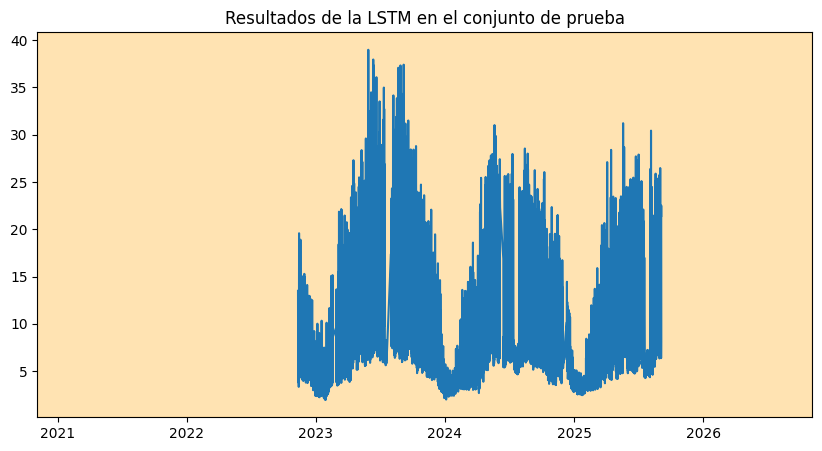

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(df["P1"], label='train')
# Definir rango a resaltar
fecha_inicio = pd.Timestamp('2020-11-4')
fecha_fin    = pd.Timestamp('2026-11-6')
# Limitar el eje X al rango deseado
plt.xlim(fecha_inicio, fecha_fin)

# Resaltar rango
plt.axvspan(fecha_inicio, fecha_fin, color='orange', alpha=0.3, label='Rango seleccionado')

plt.title('Resultados de la LSTM en el conjunto de prueba')
plt.show()

# VISUALIZACION SETS

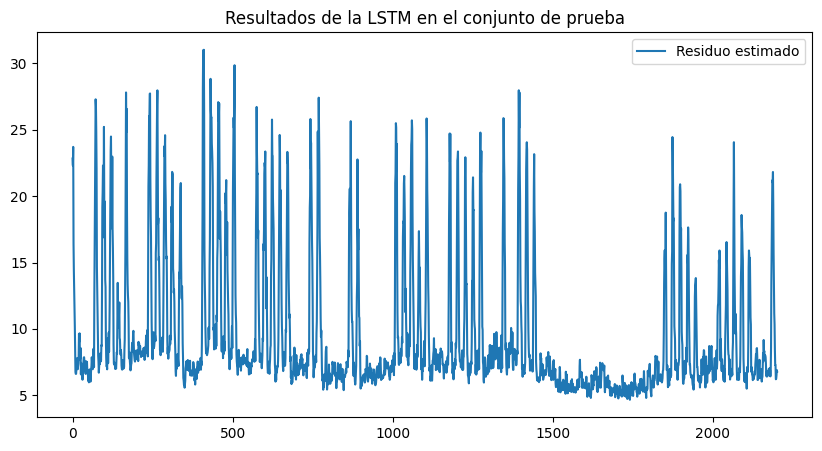

In [16]:
plt.figure(figsize=(10, 5))
#plt.plot(ytrain[:,0], label='train')
#plt.plot(yval[:,0], label='val')
plt.plot(ytest[:,:], label='Residuo estimado')

plt.legend()
plt.title('Resultados de la LSTM en el conjunto de prueba')
plt.show()

# MODELO


In [28]:
# Mode
# Asegurar reproducibilidad
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, BatchNormalization, Dense, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tensorflow.keras.layers import MaxPooling1D,MaxPool1D,GRU,LayerNormalization
from tensorflow.keras.layers import Input, LSTM, Dense, MultiHeadAttention, LayerNormalization,Attention
from tensorflow.keras.models import Model
import time


np.random.seed(47)
tf.random.set_seed(47)
initializer = GlorotUniform(seed=47)

    # Define los intervalos y los valores de learning rate
boundaries = [5, 10, 20, 50, 100, 250]  # Los límites de los intervalos (épocas en este caso)
values = [0.005, 0.002, 0.001, 0.0001, 0.00005, 0.00001, 0.000001]  # Learning rates correspondientes a los intervalos

    # Crea el scheduler de learning rate
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=boundaries,
        values=values
    )
    # Crear el modelo LSTM
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))


#model.add(Dense(32, activation="relu"))
model.add(Dense(ytrain.shape[1]))



    # Compilar el modelo con el optimizador personalizado
#optimizer = Adam(learning_rate=lr_schedule, clipnorm=1)
#model.compile(optimizer=optimizer, loss=MeanAbsolutePercentageError())
loss = tf.keras.losses.Huber(delta=1.0)
model.compile(optimizer='adam', loss=loss)


#model.compile(
#    optimizer="adam",
#    loss=lambda y_true, y_pred: custom_loss_with_tolerance(y_true, y_pred, tolerance=0.05)
#)

    # EarlyStopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=PACIENCIA_EARLY, restore_best_weights=True)

    # ModelCheckpoint para guardar el modelo durante el entrenamiento

start_total = time.time()
        # Entrenar el modelo con datos de validación, EarlyStopping y ModelCheckpoint
history = model.fit(Xtrain_n, ytrain_n, epochs=EPOCAS, verbose=1, batch_size=BATCH_SIZE,
                  validation_data=(Xval_n, yval_n), callbacks=[early_stopping])

total_time = time.time() - start_total
loss_history = history.history['loss']
val_loss_history = history.history.get('val_loss', [None]*len(loss_history))

# Época donde se restauraron los pesos (mejor val_loss)
best_epoch = val_loss_history.index(min(val_loss_history)) if val_loss_history[0] is not None else loss_history.index(min(loss_history))

# Tiempo por época aproximado
epoch_times = [total_time / len(loss_history)] * len(loss_history)  # promedio si no medimos por epoch

# -----------------------------
# 4. Guardar en un DataFrame para luego insertar en BD
# -----------------------------
df_training_info = pd.DataFrame({
    'epoch': list(range(1, len(loss_history)+1)),
    'loss': loss_history,
    'val_loss': val_loss_history,
    'epoch_time_s': epoch_times
})

training_summary = {
    'best_epoch': best_epoch + 1,  # sumo 1 porque los índices empiezan en 0
    'best_val_loss': val_loss_history[best_epoch],
    'total_time_m': total_time/60,
    'early_stopping_patience': PACIENCIA_EARLY
}

print(df_training_info)
print(training_summary)


Epoch 1/300
626/626 [==============================] - 9s 11ms/step - loss: 0.0418 - val_loss: 0.0265
Epoch 2/300
626/626 [==============================] - 6s 10ms/step - loss: 0.0284 - val_loss: 0.0251
Epoch 3/300
626/626 [==============================] - 6s 10ms/step - loss: 0.0266 - val_loss: 0.0257
Epoch 4/300
626/626 [==============================] - 6s 10ms/step - loss: 0.0257 - val_loss: 0.0253
Epoch 5/300
626/626 [==============================] - 6s 10ms/step - loss: 0.0250 - val_loss: 0.0262
Epoch 6/300
626/626 [==============================] - 6s 10ms/step - loss: 0.0241 - val_loss: 0.0284
Epoch 7/300
626/626 [==============================] - 6s 10ms/step - loss: 0.0235 - val_loss: 0.0261
Epoch 8/300
626/626 [==============================] - 6s 10ms/step - loss: 0.0231 - val_loss: 0.0269
Epoch 9/300
626/626 [==============================] - 6s 10ms/step - loss: 0.0221 - val_loss: 0.0260
Epoch 10/300
626/626 [==============================] - 6s 10ms/step - loss: 0.021

In [297]:
Xtrain_n = Xtrain_n.astype('float32')
Xval_n = Xval_n.astype('float32')
Xtest_n = Xtest_n.astype('float32')



# PREDICCIONES Y STATS

# stats multivariable


In [29]:
import numpy as np
ypred_n = model.predict(Xtest_n)
ypred = target_scaler.inverse_transform(ypred_n)

desplazamiento = 1         # usar último valor conocido

# ypred_n = model.predict(Xtest_n)
# ypred = salidas.inverse_transform(ypred_n)

n = ytest.shape[0]

# ============================
# Construir persistencia clásica: mantener último valor conocido (t-1)
# ============================
persistencias = np.zeros((n, ventana_salida))
persistencias[1:, :] = ytest[:-1, 0].reshape(-1, 1)  # replicar último valor completo en todas las columnas
persistencias[0, :] = ytest[0, 0]                    # relleno inicial

# ============================
# Detectar picos por columna
# ============================
if ytest.ndim == 1:
    cambios = np.abs(np.diff(ytest, prepend=ytest[0]))
elif ytest.ndim == 2:
    cambios = np.abs(np.diff(ytest, axis=0, prepend=ytest[0:1, :]))

mask = cambios > PICO_CONSIDERABLE

# ============================
# Calcular errores absolutos y relativos
# ============================
errores_modelo = np.abs(ypred - ytest)
errores_persistencia = np.abs(persistencias - ytest)

error_rel_modelo = np.mean(np.abs(errores_modelo / (ytest)), axis=0) * 100
error_rel_persistencia = np.mean(np.abs(errores_persistencia / (ytest)), axis=0) * 100

# ============================
# Porcentaje de mejora del modelo vs persistencia
# ============================
porcentaje_mejora = np.zeros(ventana_salida)
porcentaje_mejora50 = np.zeros(ventana_salida)

for k in range(ventana_salida):
    mejor = 0
    mejor50 = 0
    total = 0
    for i in range(desplazamiento, n):
        if mask[i, k]:
            error_m = abs(ypred[i, k] - ytest[i, k])
            error_p = abs(persistencias[i, k] - ytest[i, k])
            if error_m < error_p:
                mejor += 1
            if error_m < 0.5 * error_p:
                mejor50 += 1
            total += 1
    if total > 0:
        porcentaje_mejora[k] = 100 * mejor / total
        porcentaje_mejora50[k] = 100 * mejor50 / total
    
# ============================
# Estadísticos
# ============================
error_prom_modelo = np.mean(errores_modelo, axis=0)
error_std_modelo  = np.std(errores_modelo, axis=0)
error_prom_persist = np.mean(errores_persistencia, axis=0)
error_std_persist  = np.std(errores_persistencia, axis=0)

# ============================
# Impresión
# ============================
print("Error promedio modelo por paso:", error_prom_modelo)
print("Desvío estándar modelo por paso:", error_std_modelo)
print("Error relativo % modelo por paso:", error_rel_modelo)
print("")
print("Error promedio persistencia por paso:", error_prom_persist)
print("Desvío estándar persistencia por paso:", error_std_persist)
print("Error relativo % persistencia por paso:", error_rel_persistencia)
print("")
print("Porcentaje de mejora vs persistencia por paso:", porcentaje_mejora)
print("Porcentaje de mejora >50% vs persistencia por paso:", porcentaje_mejora50)
print(total)

79/79 [==============================] - 1s 5ms/step
Error promedio modelo por paso: [0.80773778]
Desvío estándar modelo por paso: [0.86852841]
Error relativo % modelo por paso: [9.16138651]

Error promedio persistencia por paso: [1.10177204]
Desvío estándar persistencia por paso: [1.36058382]
Error relativo % persistencia por paso: [11.18937424]

Porcentaje de mejora vs persistencia por paso: [94.04761905]
Porcentaje de mejora >50% vs persistencia por paso: [64.68253968]
252


In [47]:

# Desvío estándar relativo (%) por paso
error_std_rel_modelo = np.std(np.abs(errores_modelo / ytest), axis=0) * 100
error_std_rel_persistencia = np.std(np.abs(errores_persistencia / ytest), axis=0) * 100

print("Desvío estándar relativo modelo (%):", error_std_rel_modelo)
print("Desvío estándar relativo persistencia (%):", error_std_rel_persistencia)


Desvío estándar relativo modelo (%): [7.88800143]
Desvío estándar relativo persistencia (%): [10.81909564]


In [177]:
total_comparaciones

NameError: name 'total_comparaciones' is not defined

In [30]:
import numpy as np

umbral = 6  # el error que considerás significativo

# Calculamos error absoluto
errores = np.abs(ypred - ytest)
kept_indices
# Posiciones donde el error es mayor a umbral
posiciones_error = np.argwhere(errores > umbral)

print("Número total de errores grandes:", len(posiciones_error))
print("Indices (fila, columna) de errores > 3:\n", posiciones_error)


Número total de errores grandes: 2
Indices (fila, columna) de errores > 3:
 [[1519    0]
 [2501    0]]


In [33]:
print(ytest[1519], ypred[1519])

[17.76047434] [11.730986]


# VISUALIZACION PREDICCIONES

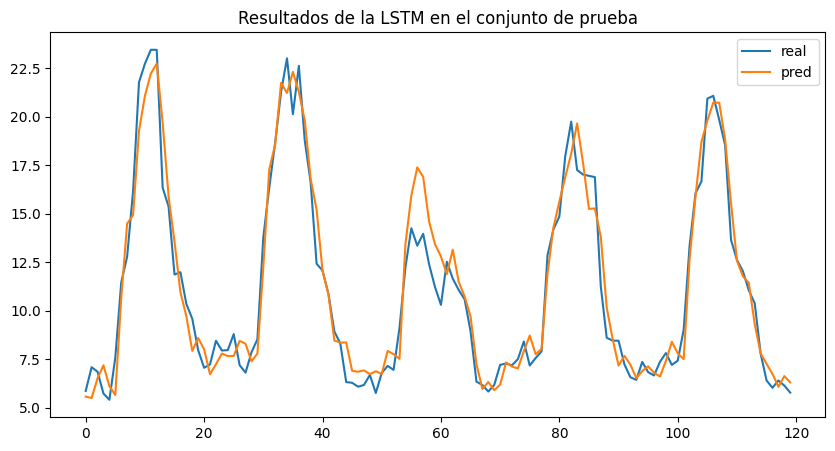

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(ytest[1080:1200,0], label='real')
plt.plot(ypred[1080:1200,0], label='pred')
#plt.plot(ypred_tft[4500:4550,0], label='predtft')



plt.legend()
plt.title('Resultados de la LSTM en el conjunto de prueba')
plt.show()

# BD

In [62]:
import sqlite3, json
from datetime import datetime
#para convertir a lista y guardar json
def to_list(x):
    if isinstance(x, np.ndarray):
        return x.tolist()
    return x

conn = sqlite3.connect("experimentos.db")
c = conn.cursor()

# Crear tabla si no existe
c.execute("""
CREATE TABLE IF NOT EXISTS experimentos (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    fecha TEXT,
    arquitectura TEXT,
    optimizer TEXT,
    metrics TEXT,
    hiperparametros TEXT,
    train_size INTEGER,
    val_size INTEGER,
    test_size INTEGER,
    train_desde TEXT,
    train_hasta TEXT,
    val_desde TEXT,
    val_hasta TEXT,
    test_desde TEXT,
    test_hasta TEXT,
    valor_pico REAL,
    cantidad_picos REAL,
    mejor_persistentes REAL,
    mejor_persistentes05 REAL,
    comentarios TEXT,
    parametros_extra TEXT
)
""")

# Ejemplo de datos de un experimento
config = json.dumps(model.get_config())
#optimizer = json.dumps(model.optimizer.get_config())

optimizer_json = json.dumps(
    model.optimizer.get_config(),
    default=lambda x: float(x) if isinstance(x, (np.float32, np.float64)) else x
)

loss = str(model.loss)
metrics = json.dumps(model.metrics_names)
metrics_json = json.dumps(metrics, default=lambda x: float(x) if isinstance(x, (np.float32, np.float64)) else x)

hiperparametros = json.dumps({"batch_size": BATCH_SIZE, "epochs": EPOCAS, "learning_rate": 0.001})
hiperparametros_json = json.dumps(hiperparametros, default=lambda x: float(x) if isinstance(x, (np.float32, np.float64)) else x)


c.execute("""
INSERT INTO experimentos (
    fecha, arquitectura, optimizer, metrics, hiperparametros, 
    train_size, val_size, test_size,
    train_desde,train_hasta,val_desde,val_hasta,test_desde,test_hasta,
    valor_pico,cantidad_picos, mejor_persistentes, mejor_persistentes05,
    comentarios, parametros_extra
) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ? )
""", (
    datetime.now().isoformat(),
    config,
    optimizer_json,
    metrics_json,
    hiperparametros_json,
    fin_train-inicio_train,   # train
    fin_val-inicio_val,    # validación
    fin_test-inicio_test,     # test
    str(FECHA_INICIO_TRAIN),
    str(FECHA_FIN_TRAIN),
    str(FECHA_INICIO_VAL),
    str(FECHA_FIN_VAL),
    str(FECHA_INICIO_TEST),
    str(FECHA_FIN_TEST),

    PICO_CONSIDERABLE,
    int(cantidad_picos),      # cantidad_picos
    porcentaje_mejora,    # mejor_persistentes (85%)
    porcentaje_mejora50,    # mejor_persistentes05 (73%)
    COMENTARIO,  # comentario libre
    json.dumps({"ventana entrada": ventana_entrada, "ventana salida": ventana_salida,
                "paciencia early": training_summary["early_stopping_patience"], 
                "tiempo train(m)": training_summary["total_time_m"], "mejor epoca": training_summary["best_epoch"],
                "umbral consideracion del dia": UMBRAL_CONSIDERACION_DIA, "dias usados": dias, "horas usadas": horas,
                "error prom modelo": to_list(error_prom_modelo), "error prom persistencia": to_list(error_prom_persist),
                "std modelo": to_list(error_std_modelo), "std persistencia": to_list(error_std_persist),
                "relativo modelo": to_list(error_rel_modelo), "relativo persistencia": to_list(error_rel_persistencia),
                "porcentaje mejora": to_list(porcentaje_mejora), "porcentaje mejora 05": to_list(porcentaje_mejora50)
                
                
                })
))

conn.commit()
id_modelo = c.lastrowid
conn.close()


def guardar_modelo_y_resultados(carpeta, modelo, scalers):
    # Guardar el modelo


    # Guardar los escaladores
    scalers_path = os.path.join(carpeta, 'scalers.pkl')
    with open(scalers_path, 'wb') as f:
        pickle.dump(scalers, f)


    return  scalers_path


# Guardar el modelo en formato recomendado (.keras)
save_dir = "modelos"
os.makedirs(save_dir, exist_ok=True)  # crea 'modelos' si no existe

# Carpeta específica para este modelo, usando el id
model_carpeta = os.path.join(save_dir, str(id_modelo))
os.makedirs(model_carpeta, exist_ok=True)

model.save(os.path.join(model_carpeta, f"{id_modelo}.keras"))

# Guardar en formato HDF5 (.h5) como alternativa
model.save(os.path.join(model_carpeta, f"{id_modelo}.h5"))
#model.save(os.path.join(model_carpeta, "modelofinal"))

guardar_modelo_y_resultados(model_carpeta,None,scalers)

C:\Users\jorge\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'modelos\\137\\scalers.pkl'

In [69]:
import sqlite3
import json

# Conectar a la BD
conn = sqlite3.connect("experimentos.db")
c = conn.cursor()

# Traer todo de la tabla
c.execute("SELECT id,comentarios,json_extract(parametros_extra, '$.\"ventana entrada\"') AS ventana_entrada, json_extract(parametros_extra, '$.\"ventana salida\"') AS ventana_salida, cantidad_picos, mejor_persistentes, mejor_persistentes05, valor_pico ,json_extract(parametros_extra, '$.\"error prom modelo\"') AS error_prom_modelo,json_extract(parametros_extra, '$.\"std modelo\"') AS estandar_modelo FROM experimentos")
rows = c.fetchall()

# Mostrar filas
for row in rows:
    print(row)

conn.close()

(1, 'solo dias habiles | promedio', 24, 1, 179.0, 95.53072625698324, 71.50837988826815, 3.0, None, None)
(2, 'solo dias habiles | promedio', 24, 1, 372.0, 95.16129032258065, 73.11827956989248, 3.0, None, None)
(3, 'solo dias habiles | max', 24, 1, 306.0, 91.50326797385621, 63.0718954248366, 3.0, None, None)
(4, 'media todos los dias', 24, 1, 165.0, 95.75757575757575, 76.36363636363637, 3.0, None, None)
(5, 'media todos los dias', 24, 1, 373.0, 95.71045576407506, 62.73458445040214, 3.0, None, None)
(6, 'media todos los dias', 24, 6, 1686.0, 81.85053380782918, 49.46619217081851, 3.0, None, None)
(7, 'media todos los dias', 168, 1, 281.0, 95.37366548042705, 76.15658362989323, 3.0, None, None)
(8, 'media todos los dias', 168, 1, 281.0, 95.01779359430606, 72.59786476868328, 3.0, None, None)
(9, 'media todos los dias', 24, 1, 451.0, 93.56984478935698, 54.32372505543237, 2.0, None, None)
(10, 'media todos los dias, 2 picos distintos (valor y valor*2)', 24, 1, 451.0, 92.23946784922394, 58.7583

In [54]:
import sqlite3
import json

# Conectar a la BD
conn = sqlite3.connect("experimentos.db")
c = conn.cursor()

# Traer todo de la tabla
c.execute("SELECT id,comentarios,json_extract(parametros_extra, '$.\"ventana entrada\"') AS ventana_entrada, json_extract(parametros_extra, '$.\"ventana salida\"') AS ventana_salida ,json_extract(parametros_extra, '$.\"error prom modelo\"') AS error_prom_modelo,json_extract(parametros_extra, '$.\"std modelo\"') AS estandar_modelo FROM experimentos WHERE json_extract(parametros_extra, '$.\"ventana salida\"') =1")
rows = c.fetchall()

# Mostrar filas
for row in rows:
    print(row)

conn.close()

(1, 'solo dias habiles | promedio', 24, 1, None, None)
(2, 'solo dias habiles | promedio', 24, 1, None, None)
(3, 'solo dias habiles | max', 24, 1, None, None)
(4, 'media todos los dias', 24, 1, None, None)
(5, 'media todos los dias', 24, 1, None, None)
(7, 'media todos los dias', 168, 1, None, None)
(8, 'media todos los dias', 168, 1, None, None)
(9, 'media todos los dias', 24, 1, None, None)
(10, 'media todos los dias, 2 picos distintos (valor y valor*2)', 24, 1, None, None)
(11, 'minimo todos los dias', 24, 1, None, None)
(12, 'media todos los dias + feature diferencia', 24, 1, None, None)
(14, 'media todos los dias, mezcla train', 24, 1, '[0.9742688587857296]', '[1.2264728576505686]')
(15, 'media todos los dias idem previo, sin mezcla train', 24, 1, '[0.975597783501451]', '[1.216910048913886]')
(16, 'media todos los dias, df balanceado', 48, 1, '[0.9568861615028238]', '[1.2116950193973186]')
(21, 'media todos los dias, modelo 256', 6, 1, '[1.0059384586443343]', '[1.1478156233148937

# version porcentual con semanal la codificacion


MODE = mark
crear ventana generó  (16658, 24, 61)
Xtrain: (12001, 24, 61)
Xval: (2001, 24, 61)
Xtest: (2202, 24, 61)
69/69 [==============================] - 1s 4ms/step

Resumen agrupado por hora de inicio del horizonte:
    hora_inicio  mean_error_rel  mean_abs_error_rel  max_error_rel_prom  \
0             0       -0.010402            0.045297            0.045297   
1             1        0.007641            0.067842            0.067842   
2             2        0.039884            0.057267            0.057267   
3             3        0.010577            0.061282            0.061282   
4             4        0.021751            0.064163            0.064163   
5             5        0.038474            0.078500            0.078500   
6             6        0.039353            0.084758            0.084758   
7             7       -0.062295            0.095640            0.095640   
8             8       -0.020822            0.117181            0.117181   
9             9        0.019

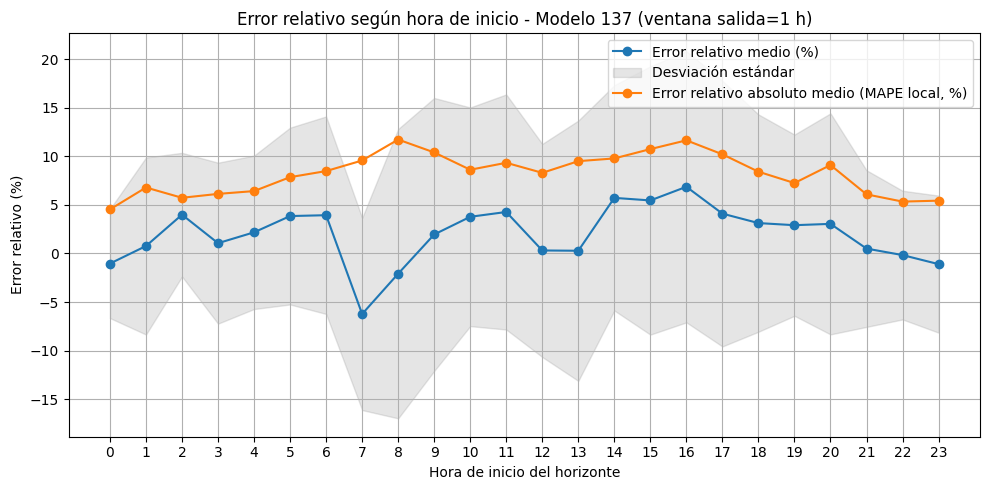

✅ Gráfico guardado como: documentacion/plots\error_relativo_modelo_137.png


In [63]:
import os
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import sqlite3
import matplotlib.pyplot as plt
mediciones_previas= 1
# ==========================================================
# CONFIGURACIÓN
# ==========================================================
UMBRAL_CONSIDERACION_DIA = 13
PICO_CONSIDERABLE = 3

# ==========================================================
# FUNCIONES AUXILIARES
# ==========================================================
def obtener_parametros_bd(id_modelo):
    conn = sqlite3.connect("experimentos.db")
    c = conn.cursor()
    c.execute("""
        SELECT 
            json_extract(parametros_extra, '$.\"ventana entrada\"'),
            json_extract(parametros_extra, '$.\"ventana salida\"')
        FROM experimentos
        WHERE id = ?
    """, (id_modelo,))
    row = c.fetchone()
    conn.close()
    if not row or row[0] is None or row[1] is None:
        raise ValueError(f"No se encontraron parámetros para el modelo {id_modelo}")
    return int(row[0]), int(row[1])


def preparar_datos_test(ventana_entrada, ventana_salida):

    dias = list(range(7))
    horas = list(range(24))
    df = cargar_datos_especificos_nuevo2_semanal(
        'potencia.csv', dias_semanales=dias, horas=horas
    )
    # eliminar rangos estacionales
    for y in ["2022", "2023", "2024"]:
        df = df.drop(df.loc[f"{y}-12-7":f"{int(y)+1}-3-12"].index, errors='ignore')
    X, y, kept_indices = crear_ventana_nuevo_lags_dft(df, ventana_entrada, ventana_salida)

    kept_indices = np.array(kept_indices)

    print("crear ventana generó ", X.shape)

    # --- DEFINICIÓN DE LOS LÍMITES SOBRE EL DF (IGUAL QUE ANTES) ---
    inicio_train = 0
    fin_train = 12000

    FECHA_INICIO_TRAIN = df.index[inicio_train]
    FECHA_FIN_TRAIN    = df.index[fin_train]

    inicio_val = fin_train + 1
    fin_val    = fin_train + 1 + 2000

    FECHA_INICIO_VAL = df.index[inicio_val]
    FECHA_FIN_VAL    = df.index[fin_val]

    inicio_test = fin_val + 1 #2200
    fin_test = min(inicio_test + 1 + 2200, len(df)-1)

    FECHA_INICIO_TEST = df.index[inicio_test]
    FECHA_FIN_TEST    = df.index[fin_test]


    # --- CONVERSIÓN: índices del DF → índices dentro de X/Y ---
    mask_train = (kept_indices >= inicio_train) & (kept_indices <= fin_train)
    mask_val   = (kept_indices >= inicio_val)   & (kept_indices <= fin_val)
    mask_test  = (kept_indices >= inicio_test)  & (kept_indices <= fin_test)

    train_idx = np.where(mask_train)[0]
    val_idx   = np.where(mask_val)[0]
    test_idx  = np.where(mask_test)[0]


    # --- SPLITS FINALES ---
    Xtrain = X[train_idx]
    ytrain = y[train_idx]

    Xval = X[val_idx]
    yval = y[val_idx]

    Xtest = X[test_idx]
    ytest = y[test_idx]

    print("Xtrain:", Xtrain.shape)
    print("Xval:",   Xval.shape)
    print("Xtest:",  Xtest.shape)

    return Xtest, ytest, df.index[test_idx]


def cargar_modelo_y_scalers(id_modelo):
    carpeta = os.path.join("modelos", str(id_modelo))
    model = tf.keras.models.load_model(os.path.join(carpeta, f"{id_modelo}.h5"))
    with open(os.path.join(carpeta, "scalers.pkl"), "rb") as f:
        scalers = pickle.load(f)
    return model, scalers


def normalizar_datos(Xtest, scalers):
    scaler = scalers["input_scaler"]
    N, T, F = Xtest.shape

    X2d = Xtest.reshape(-1, F)
    X2d_scaled = scaler.transform(X2d)
    return X2d_scaled.reshape(N, T, F)




# ==========================================================
# PRINCIPAL
# ==========================================================
def generar_predicciones(id_modelo):
    ve, vs = obtener_parametros_bd(id_modelo)
    model, scalers = cargar_modelo_y_scalers(id_modelo)

    Xtest, ytest, horas_test = preparar_datos_test(ve, vs)
    Xtest_n = normalizar_datos(Xtest, scalers)
    Xtest_n = np.asarray(Xtest_n, dtype=np.float32)

    ypred = scalers['target_scaler'].inverse_transform(model.predict(Xtest_n))

    # ---- Construir resultados por paso dentro de cada ventana
    data = []
    for i in range(len(ypred)):
        hora_inicio_horizonte = horas_test[i] + pd.Timedelta(hours=ve)
        for paso in range(ypred.shape[1]):
            hora_prediccion = hora_inicio_horizonte + pd.Timedelta(hours=paso)
            data.append({
                "ventana_id": i,
                "paso": paso,
                "prediccion": float(ypred[i, paso]),
                "real": float(ytest[i, paso]) if paso < ytest.shape[1] else np.nan,
                "hora_pred": hora_prediccion
            })

    df = pd.DataFrame(data)
    df["hora_pred"] = pd.to_datetime(df["hora_pred"])
    df["hora_dia"] = df["hora_pred"].dt.hour

    # =====================================================
    # Cálculo de errores relativos
    # =====================================================
    df["error"] = df["prediccion"] - df["real"]
    df["error_rel"] = np.where(df["real"] != 0, df["error"] / df["real"], np.nan)
    df["error_rel_abs"] = np.abs(df["error_rel"])

    # =====================================================
    # 1. Agrupar por ventana (con error relativo máximo)
    # =====================================================
    errores_por_ventana = (
        df.groupby("ventana_id")
        .agg(
            error_rel_mean=("error_rel", "mean"),
            error_rel_abs_mean=("error_rel_abs", "mean"),
            error_rel_max=("error_rel_abs", "max"),
            error_rel_std=("error_rel", "std"),
            real_mean=("real", "mean"),
            hora_inicio_horizonte=("hora_pred", "min")
        )
        .reset_index()
    )

    errores_por_ventana["hora_inicio"] = errores_por_ventana["hora_inicio_horizonte"].dt.hour

    # =====================================================
    # 2. Reagrupar por la hora de inicio del horizonte
    # =====================================================
    errores_por_hora = (
        errores_por_ventana
        .groupby("hora_inicio")
        .agg(
            mean_error_rel=("error_rel_mean", "mean"),
            mean_abs_error_rel=("error_rel_abs_mean", "mean"),
            max_error_rel_prom=("error_rel_max", "mean"),
            std_error_rel=("error_rel_mean", "std"),
            real_promedio=("real_mean", "mean"),
            n_ventanas=("ventana_id", "count")
        )
        .reset_index()
        .sort_values("hora_inicio")
    )

    print("\nResumen agrupado por hora de inicio del horizonte:")
    print(errores_por_hora)

    # =====================================================
    # 3. Graficar patrones (en %)
    # =====================================================
    plt.figure(figsize=(10, 5))
    plt.plot(
        errores_por_hora["hora_inicio"],
        errores_por_hora["mean_error_rel"] * 100,
        marker="o",
        label="Error relativo medio (%)"
    )

    # Rango de dispersión (±1 desviación estándar)
    plt.fill_between(
        errores_por_hora["hora_inicio"],
        (errores_por_hora["mean_error_rel"] - errores_por_hora["std_error_rel"]) * 100,
        (errores_por_hora["mean_error_rel"] + errores_por_hora["std_error_rel"]) * 100,
        color="gray", alpha=0.2, label="Desviación estándar"
    )

    plt.plot(
        errores_por_hora["hora_inicio"],
        errores_por_hora["mean_abs_error_rel"] * 100,
        marker="o",
        label="Error relativo absoluto medio (MAPE local, %)"
    )

    plt.xticks(errores_por_hora["hora_inicio"])
    plt.title(f"Error relativo según hora de inicio - Modelo {id_modelo} (ventana salida={vs} h)")
    plt.xlabel("Hora de inicio del horizonte")
    plt.ylabel("Error relativo (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    os.makedirs("documentacion/plots", exist_ok=True)
    nombre_archivo = os.path.join("documentacion/plots", f"error_relativo_modelo_{id_modelo}.png")
    plt.savefig(nombre_archivo, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"✅ Gráfico guardado como: {nombre_archivo}")
    return errores_por_ventana, errores_por_hora


# ==========================================================
# EJECUCIÓN
# ==========================================================
if __name__ == "__main__":
    errores_por_ventana, errores_por_hora = generar_predicciones(137)

Index(['P1', 'dia_sen', 'dia_cos', 'mes_sen', 'mes_cos', 'pico', 'lunes',
       'martes', 'miercoles', 'jueves', 'viernes', 'sabado', 'domingo',
       'dia_habil', 'dia_incompleto', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
       'lag6', 'lag24', 'delta1', 'delta2', 'delta3', 'delta4', 'delta5',
       'delta6', 'delta24', 'h_0', 'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6',
       'h_7', 'h_8', 'h_9', 'h_10', 'h_11', 'h_12', 'h_13', 'h_14', 'h_15',
       'h_16', 'h_17', 'h_18', 'h_19', 'h_20', 'h_21', 'h_22', 'h_23'],
      dtype='object')
MODE = mark
[[ 1.34974282e+01 -5.00000000e-01 -8.66025404e-01 ...  1.48031267e+01
   9.84004193e+00  1.04541793e+01]
 [ 1.28915381e+01 -7.07106781e-01 -7.07106781e-01 ...  1.48031267e+01
   9.84004193e+00  1.04541793e+01]
 [ 1.23011408e+01 -8.66025404e-01 -5.00000000e-01 ...  1.48031267e+01
   9.84004193e+00  1.04541793e+01]
 ...
 [ 5.61464469e+00  2.58819045e-01 -9.65925826e-01 ...  1.48031267e+01
   9.84004193e+00  1.04541793e+01]
 [ 6.45059521e+00 

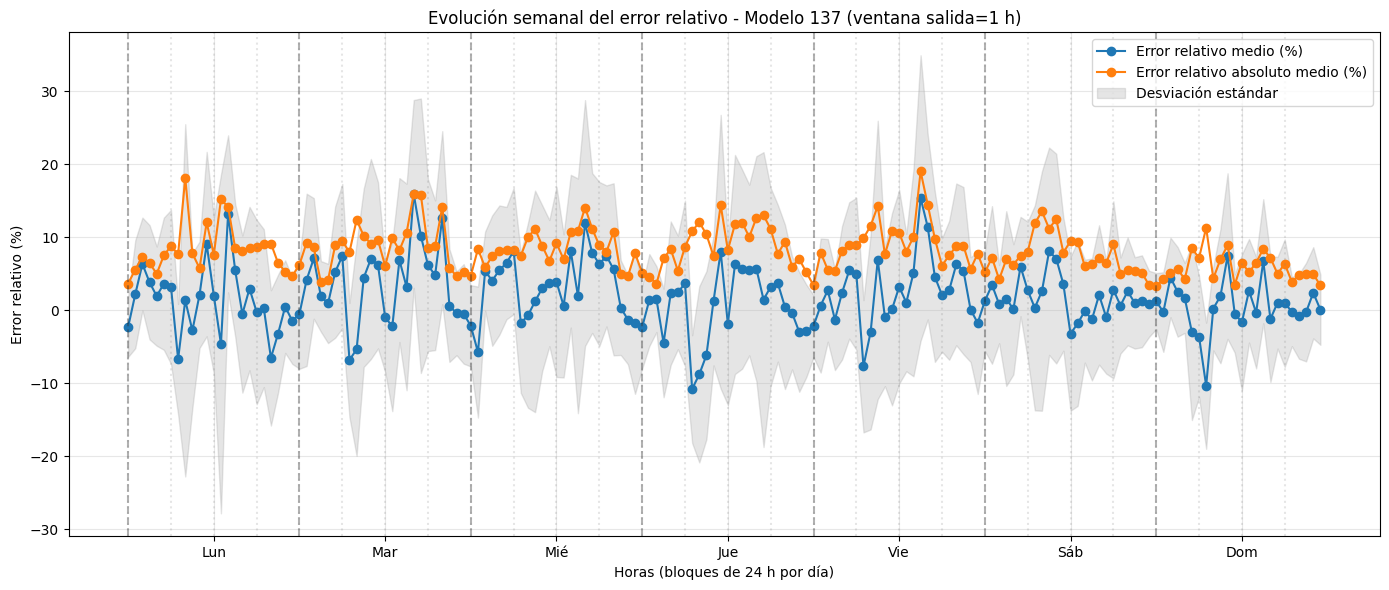

✅ Gráfico guardado como: documentacion/plots\error_relativo_semanal_modelo_137.png


In [64]:
import os
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import sqlite3
import matplotlib.pyplot as plt

# ==========================================================
# CONFIGURACIÓN
# ==========================================================
UMBRAL_CONSIDERACION_DIA = 13
PICO_CONSIDERABLE = 3

# ==========================================================
# FUNCIONES AUXILIARES
# ==========================================================
def obtener_parametros_bd(id_modelo):
    conn = sqlite3.connect("experimentos.db")
    c = conn.cursor()
    c.execute("""
        SELECT 
            json_extract(parametros_extra, '$.\"ventana entrada\"'),
            json_extract(parametros_extra, '$.\"ventana salida\"')
        FROM experimentos
        WHERE id = ?
    """, (id_modelo,))
    row = c.fetchone()
    conn.close()
    if not row or row[0] is None or row[1] is None:
        raise ValueError(f"No se encontraron parámetros para el modelo {id_modelo}")
    return int(row[0]), int(row[1])


def preparar_datos_test(ventana_entrada, ventana_salida, mediciones_previas=1):
    dias = [0,1,2,3,4,5,6]
    horas = list(range(24))
    df = cargar_datos_especificos_nuevo2_semanal(
        'potencia.csv', dias_semanales=dias, horas=horas
    )
    print(df.columns)
    # eliminar rangos estacionales
    for y in ["2022", "2023", "2024"]:
        df = df.drop(df.loc[f"{y}-12-7":f"{int(y)+1}-3-12"].index, errors='ignore')
    X, y, kept_indices = crear_ventana_nuevo_lags_dft(df, ventana_entrada, ventana_salida)
    print(X[0])
    kept_indices = np.array(kept_indices)

    print("crear ventana generó ", X.shape)

    # --- DEFINICIÓN DE LOS LÍMITES SOBRE EL DF (IGUAL QUE ANTES) ---
    inicio_train = 0
    fin_train = 12000#12000 

    FECHA_INICIO_TRAIN = df.index[inicio_train]
    FECHA_FIN_TRAIN    = df.index[fin_train]

    inicio_val = fin_train + 1
    fin_val    = fin_train + 1 + 2000#2000

    FECHA_INICIO_VAL = df.index[inicio_val]
    FECHA_FIN_VAL    = df.index[fin_val]

    inicio_test = fin_val + 1 #2200
    fin_test = min(inicio_test + 1 + 2200, len(df)-1)

    FECHA_INICIO_TEST = df.index[inicio_test]
    FECHA_FIN_TEST    = df.index[fin_test]


    # --- CONVERSIÓN: índices del DF → índices dentro de X/Y ---
    mask_train = (kept_indices >= inicio_train) & (kept_indices <= fin_train)
    mask_val   = (kept_indices >= inicio_val)   & (kept_indices <= fin_val)
    mask_test  = (kept_indices >= inicio_test)  & (kept_indices <= fin_test)

    train_idx = np.where(mask_train)[0]
    val_idx   = np.where(mask_val)[0]
    test_idx  = np.where(mask_test)[0]


    # --- SPLITS FINALES ---
    Xtrain = X[train_idx]
    ytrain = y[train_idx]

    Xval = X[val_idx]
    yval = y[val_idx]

    Xtest = X[test_idx]
    ytest = y[test_idx]

    print("Xtrain:", Xtrain.shape)
    print("Xval:",   Xval.shape)
    print("Xtest:",  Xtest.shape)



    return Xtest, ytest, df.index[test_idx]


def cargar_modelo_y_scalers(id_modelo):
    carpeta = os.path.join("modelos", str(id_modelo))
    model = tf.keras.models.load_model(os.path.join(carpeta, f"{id_modelo}.h5"))
    with open(os.path.join(carpeta, "scalers.pkl"), "rb") as f:
        scalers = pickle.load(f)
    return model, scalers

def normalizar_datos(Xtest, scalers):
    scaler = scalers["input_scaler"]
    N, T, F = Xtest.shape

    X2d = Xtest.reshape(-1, F)
    X2d_scaled = scaler.transform(X2d)
    return X2d_scaled.reshape(N, T, F)


# ==========================================================
# PRINCIPAL
# ==========================================================
def generar_predicciones(id_modelo):
    ve, vs = obtener_parametros_bd(id_modelo)
    model, scalers = cargar_modelo_y_scalers(id_modelo)
    Xtest, ytest, horas_test = preparar_datos_test(ve, vs)
    Xtest_n = normalizar_datos(Xtest, scalers)
    Xtest_n = np.asarray(Xtest_n, dtype=np.float32)

    ypred = scalers['target_scaler'].inverse_transform(model.predict(Xtest_n))

    # ---- Construir resultados por paso dentro de cada ventana
    data = []
    for i in range(len(ypred)):
        hora_inicio_horizonte = horas_test[i] + pd.Timedelta(hours=ve)
        for paso in range(ypred.shape[1]):
            hora_prediccion = hora_inicio_horizonte + pd.Timedelta(hours=paso)
            data.append({
                "ventana_id": i,
                "paso": paso,
                "prediccion": float(ypred[i, paso]),
                "real": float(ytest[i, paso]) if paso < ytest.shape[1] else np.nan,
                "hora_pred": hora_prediccion
            })

    df = pd.DataFrame(data)
    df["hora_pred"] = pd.to_datetime(df["hora_pred"])
    df["hora_dia"] = df["hora_pred"].dt.hour
    df["dia_semana"] = df["hora_pred"].dt.dayofweek  # lunes=0 ... domingo=6

    # =====================================================
    # Cálculo de errores relativos
    # =====================================================
    df["error"] = df["prediccion"] - df["real"]
    df["error_rel"] = np.where(df["real"] != 0, df["error"] / df["real"], np.nan)
    df["error_rel_abs"] = np.abs(df["error_rel"])

    # =====================================================
    # 1. Agrupar por ventana
    # =====================================================
    errores_por_ventana = (
        df.groupby(["ventana_id", "dia_semana"])
        .agg(
            error_rel_mean=("error_rel", "mean"),
            error_rel_abs_mean=("error_rel_abs", "mean"),
            error_rel_std=("error_rel", "std"),
            real_mean=("real", "mean"),
            hora_inicio_horizonte=("hora_pred", "min")
        )
        .reset_index()
    )

    errores_por_ventana["hora_inicio"] = errores_por_ventana["hora_inicio_horizonte"].dt.hour

    # =====================================================
    # 2. Agrupar por día y hora
    # =====================================================
    errores_por_dia_hora = (
        errores_por_ventana
        .groupby(["dia_semana", "hora_inicio"])
        .agg(
            mean_error_rel=("error_rel_mean", "mean"),
            mean_abs_error_rel=("error_rel_abs_mean", "mean"),
            std_error_rel=("error_rel_mean", "std"),
            real_promedio=("real_mean", "mean")
        )
        .reset_index()
    )

    # =====================================================
    # 3. Crear eje temporal concatenado
    # =====================================================
    errores_por_dia_hora["hora_global"] = (
        errores_por_dia_hora["dia_semana"] * 24 + errores_por_dia_hora["hora_inicio"]
    )

    # =====================================================
    # 4. Graficar concatenado (una semana completa)
    # =====================================================
    
    dias_labels = ["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"]

    plt.figure(figsize=(14, 6))

    # Error relativo medio
    plt.plot(
        errores_por_dia_hora["hora_global"],
        errores_por_dia_hora["mean_error_rel"] * 100,
        marker="o",
        label="Error relativo medio (%)"
    )   
    print("Día inicial de la semana:", errores_por_dia_hora["dia_semana"].min())


    # Error relativo absoluto medio (MAPE local)
    plt.plot(
        errores_por_dia_hora["hora_global"],
        errores_por_dia_hora["mean_abs_error_rel"] * 100,
        marker="o",
        label="Error relativo absoluto medio (%)"
    )

    # Rango de desviación estándar
    plt.fill_between(
        errores_por_dia_hora["hora_global"],
        (errores_por_dia_hora["mean_error_rel"] - errores_por_dia_hora["std_error_rel"]) * 100,
        (errores_por_dia_hora["mean_error_rel"] + errores_por_dia_hora["std_error_rel"]) * 100,
        color="gray", alpha=0.2, label="Desviación estándar"
    )

    # Líneas separando los días
    for d in range(0, 7):
        plt.axvline(x=d * 24, color="black", linestyle="--", alpha=0.3)

    # Líneas cada 6 horas
    for h in range(0, 24 * 7, 6):
        plt.axvline(x=h, color="gray", linestyle=":", alpha=0.2)

    plt.xticks(
        ticks=[d * 24 + 12 for d in range(7)],
        labels=dias_labels
    )

    plt.title(f"Evolución semanal del error relativo - Modelo {id_modelo} (ventana salida={vs} h)")
    plt.xlabel("Horas (bloques de 24 h por día)")
    plt.ylabel("Error relativo (%)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

#Guardar figura
    os.makedirs("documentacion/plots", exist_ok=True)
    nombre_archivo = os.path.join("documentacion/plots", f"error_relativo_semanal_modelo_{id_modelo}.png")
    plt.savefig(nombre_archivo, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"✅ Gráfico guardado como: {nombre_archivo}")
    return errores_por_dia_hora


# ==========================================================
# EJECUCIÓN
# ==========================================================
if __name__ == "__main__":
    errores_por_dia_hora = generar_predicciones(137)


In [66]:
import os
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import sqlite3
import matplotlib.pyplot as plt

# ==========================================================
# CONFIGURACIÓN
# ==========================================================
UMBRAL_CONSIDERACION_DIA = 13

# ==========================================================
# FUNCIONES DE CARGA (Asegúrate de tenerlas definidas o importadas)
# ==========================================================
# ... (Mantén tus funciones obtener_parametros_bd, preparar_datos_test, cargar_modelo_y_scalers, normalizar_datos aquí) ...

# ==========================================================
# PRINCIPAL MEJORADO
# ==========================================================
def generar_predicciones_detalladas(id_modelo):
    print(f"--- Procesando Modelo {id_modelo} ---")
    ve, vs = obtener_parametros_bd(id_modelo)
    model, scalers = cargar_modelo_y_scalers(id_modelo)
    
    # Cargar datos
    Xtest, ytest, horas_test = preparar_datos_test(ve, vs)
    
    # Predecir
    Xtest_n = normalizar_datos(Xtest, scalers)
    Xtest_n = np.asarray(Xtest_n, dtype=np.float32)
    
    # Des-escalar (Volver a unidades reales)
    # OJO: Si tus datos originales eran muy pequeños, esto puede dar decimales largos.
    ypred_raw = model.predict(Xtest_n)
    ypred = scalers['target_scaler'].inverse_transform(ypred_raw)

    # ---------------------------------------------------------
    # CONSTRUCCIÓN DE LA TABLA DESAGREGADA
    # ---------------------------------------------------------
    data = []
    for i in range(len(ypred)):
        # La hora base de esta ventana (cuando empieza a predecir)
        hora_inicio_horizonte = horas_test[i] + pd.Timedelta(hours=ve)
        
        for paso in range(ypred.shape[1]):
            # Hora real que se está prediciendo
            hora_prediccion = hora_inicio_horizonte + pd.Timedelta(hours=paso)
            
            valor_pred = float(ypred[i, paso])
            valor_real = float(ytest[i, paso]) if paso < ytest.shape[1] else np.nan
            
            # Evitar errores raros de división por cero
            if valor_real != 0 and not np.isnan(valor_real):
                error_abs = valor_pred - valor_real
                error_rel = error_abs / valor_real
            else:
                error_abs = np.nan
                error_rel = np.nan

            data.append({
                "fecha_exacta": hora_prediccion,         # Ej: 2024-03-01 10:00:00
                "dia_semana_num": hora_prediccion.dayofweek, 
                "hora_del_dia": hora_prediccion.hour,    # 0 a 23
                "prediccion": valor_pred,
                "real": valor_real,
                "error_absoluto": error_abs,             # Diferencia en unidades (Watts/kW)
                "error_relativo": error_rel,             # % en decimal (0.10 = 10%)
                "ventana_origen_id": i,                  # De qué bloque de predicción vino
                "paso_futuro": paso                      # Qué tan lejos estaba esta predicción (horizonte)
            })

    df = pd.DataFrame(data)

    # Mapeo de días para leer fácil
    dias_map = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
    df["nombre_dia"] = df["dia_semana_num"].map(dias_map)

    # ---------------------------------------------------------
    # ANÁLISIS DE LA DESVIACIÓN (RESPUESTA A TU PREGUNTA)
    # ---------------------------------------------------------
    # Vamos a aislar los datos tal cual los usa el gráfico para calcular la std
    # Ejemplo: Filtremos todos los "Lunes a las 10:00" para que veas la lista
    
    print("\n--- EJEMPLO DE DIAGNÓSTICO: ¿Por qué la desviación es alta el Lunes a las 10hs? ---")
    filtro_lunes_10 = df[ (df["nombre_dia"] == "Lunes") & (df["hora_del_dia"] == 10) ]
    
    if not filtro_lunes_10.empty:
        # Mostramos los peores errores de ese grupo específico
        print(filtro_lunes_10[["fecha_exacta", "real", "prediccion", "error_relativo"]]
              .sort_values(by="error_relativo", key=abs, ascending=False)
              .head(10))
        
        std_lunes_10 = filtro_lunes_10["error_relativo"].std() * 100
        print(f"\n>> La Desviación Estándar para Lunes 10:00 es: {std_lunes_10:.2f}%")
        print(">> Mira la tabla de arriba. Si ves valores con error 0.05 y otros con 0.80, ¡ahí está tu desviación!")
    else:
        print("No se encontraron datos para Lunes a las 10hs en el conjunto de test.")


    # ---------------------------------------------------------
    # EXPORTACIÓN LIMPIA (SIN NÚMEROS CIENTÍFICOS)
    # ---------------------------------------------------------
    nombre_csv = f"auditoria_errores_modelo_{id_modelo}.csv"
    
    # float_format='%.3f' fuerza a que se escriba 120.450 en vez de 1.20e+02
    df.to_csv(nombre_csv, index=False, sep=';', decimal=',', float_format='%.3f')
    
    print(f"\n✅ Archivo guardado: {nombre_csv}")
    print("   -> Columnas clave: 'nombre_dia', 'hora_del_dia', 'real', 'prediccion'")
    print("   -> Abre Excel, filtra por Hora=10 y Dia=Lunes, y verás la lista completa que genera la varianza.")

    return df

# ==========================================================
# EJECUCIÓN
# ==========================================================
if __name__ == "__main__":
    # Asegúrate de llamar a esta nueva función
    df_resultado = generar_predicciones_detalladas(137)

--- Procesando Modelo 137 ---
MODE = mark
69/69 [==============================] - 1s 3ms/step

--- EJEMPLO DE DIAGNÓSTICO: ¿Por qué la desviación es alta el Lunes a las 10hs? ---
            fecha_exacta       real  prediccion  error_relativo
837  2025-06-16 10:00:00   6.499423    7.418177        0.141359
333  2025-05-26 10:00:00  15.582871   17.445137        0.119507
1425 2025-07-14 10:00:00  16.313448   17.805588        0.091467
1166 2025-06-30 10:00:00  19.091572   20.710899        0.084819
1929 2025-08-04 10:00:00  23.016219   21.195147       -0.079121
2097 2025-08-11 10:00:00  21.474388   19.866148       -0.074891
1593 2025-07-21 10:00:00   5.619932    5.780514        0.028574
1761 2025-07-28 10:00:00   6.670947    6.508937       -0.024286
998  2025-06-23 10:00:00  19.845569   19.478689       -0.018487
501  2025-06-02 10:00:00  19.307771   19.026089       -0.014589

>> La Desviación Estándar para Lunes 10:00 es: 7.29%
>> Mira la tabla de arriba. Si ves valores con error 0.05 y ot

MODE = mark
69/69 [==============================] - 1s 3ms/step


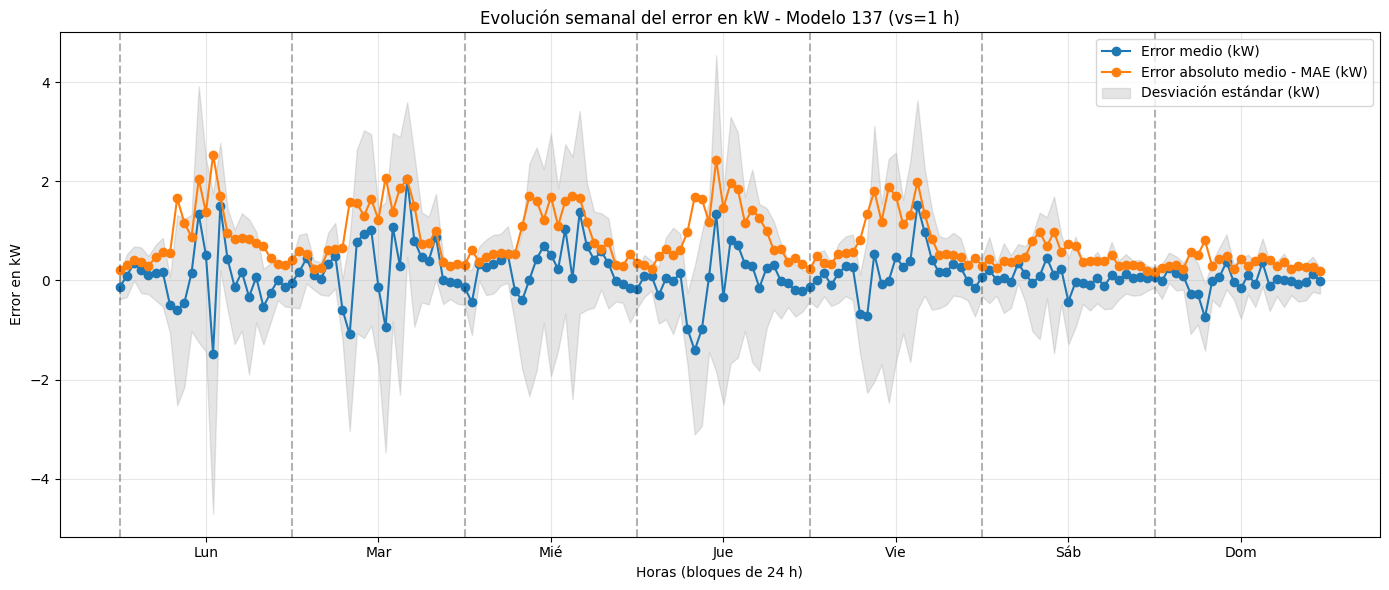

✅ Gráfico guardado como: documentacion/plots\error_kw_semanal_modelo_137.png


In [68]:
import os
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import sqlite3
import matplotlib.pyplot as plt

# ==========================================================
# CONFIGURACIÓN
# ==========================================================
UMBRAL_CONSIDERACION_DIA = 13
PICO_CONSIDERABLE = 3

# ==========================================================
# FUNCIONES AUXILIARES
# ==========================================================
def obtener_parametros_bd(id_modelo):
    conn = sqlite3.connect("experimentos.db")
    c = conn.cursor()
    c.execute("""
        SELECT 
            json_extract(parametros_extra, '$.\"ventana entrada\"'),
            json_extract(parametros_extra, '$.\"ventana salida\"')
        FROM experimentos
        WHERE id = ?
    """, (id_modelo,))
    row = c.fetchone()
    conn.close()
    if not row or row[0] is None or row[1] is None:
        raise ValueError(f"No se encontraron parámetros para el modelo {id_modelo}")
    return int(row[0]), int(row[1])


def preparar_datos_test(ventana_entrada, ventana_salida, mediciones_previas=1):
    dias = [0,1,2,3,4,5,6]
    horas = list(range(24))
    df = cargar_datos_especificos_nuevo2_semanal(
        'potencia.csv', dias_semanales=dias, horas=horas
    )

    # eliminar rangos estacionales
    for y in ["2022", "2023", "2024"]:
        df = df.drop(df.loc[f"{y}-12-7":f"{int(y)+1}-3-12"].index, errors='ignore')

    X, y, kept_indices = crear_ventana_nuevo_lags_dft(df, ventana_entrada, ventana_salida)
    kept_indices = np.array(kept_indices)

    # --- límites ---
    inicio_train = 0
    fin_train = 12000

    inicio_val = fin_train + 1
    fin_val    = fin_train + 1 + 2000

    inicio_test = fin_val + 1
    fin_test = min(inicio_test + 1 + 2200, len(df)-1)

    # --- conversiones ---
    mask_train = (kept_indices >= inicio_train) & (kept_indices <= fin_train)
    mask_val   = (kept_indices >= inicio_val)   & (kept_indices <= fin_val)
    mask_test  = (kept_indices >= inicio_test)  & (kept_indices <= fin_test)

    test_idx   = np.where(mask_test)[0]

    Xtest = X[test_idx]
    ytest = y[test_idx]

    return Xtest, ytest, df.index[test_idx]


def cargar_modelo_y_scalers(id_modelo):
    carpeta = os.path.join("modelos", str(id_modelo))
    model = tf.keras.models.load_model(os.path.join(carpeta, f"{id_modelo}.h5"))
    with open(os.path.join(carpeta, "scalers.pkl"), "rb") as f:
        scalers = pickle.load(f)
    return model, scalers


def normalizar_datos(Xtest, scalers):
    scaler = scalers["input_scaler"]
    N, T, F = Xtest.shape
    X2d = Xtest.reshape(-1, F)
    X2d_scaled = scaler.transform(X2d)
    return X2d_scaled.reshape(N, T, F)


# ==========================================================
# PRINCIPAL
# ==========================================================
def generar_predicciones(id_modelo):
    ve, vs = obtener_parametros_bd(id_modelo)
    model, scalers = cargar_modelo_y_scalers(id_modelo)

    # --- preparar test ---
    Xtest, ytest, horas_test = preparar_datos_test(ve, vs)
    Xtest_n = normalizar_datos(Xtest, scalers).astype(np.float32)

    # --- predicción ---
    ypred = scalers['target_scaler'].inverse_transform(model.predict(Xtest_n))

    # =====================================================
    # Construir tabla de resultados
    # =====================================================
    data = []
    for i in range(len(ypred)):
        hora_inicio_horizonte = horas_test[i] + pd.Timedelta(hours=ve)
        for paso in range(ypred.shape[1]):
            hora_prediccion = hora_inicio_horizonte + pd.Timedelta(hours=paso)
            data.append({
                "ventana_id": i,
                "paso": paso,
                "prediccion": float(ypred[i, paso]),
                "real": float(ytest[i, paso]) if paso < ytest.shape[1] else np.nan,
                "hora_pred": hora_prediccion
            })

    df = pd.DataFrame(data)
    df["hora_pred"] = pd.to_datetime(df["hora_pred"])
    df["hora_dia"] = df["hora_pred"].dt.hour
    df["dia_semana"] = df["hora_pred"].dt.dayofweek

    # =====================================================
    # ERRORES EN kW (NO porcentuales)
    # =====================================================
    df["error"] = df["prediccion"] - df["real"]
    df["abs_error"] = np.abs(df["error"])

    # =====================================================
    # 1. Agrupar por ventana en kW
    # =====================================================
    errores_por_ventana = (
        df.groupby(["ventana_id", "dia_semana"])
        .agg(
            error_mean_kw=("error", "mean"),
            error_abs_mean_kw=("abs_error", "mean"),   # MAE local
            error_std_kw=("error", "std"),
            real_mean_kw=("real", "mean"),
            hora_inicio_horizonte=("hora_pred", "min")
        )
        .reset_index()
    )
    errores_por_ventana["hora_inicio"] = errores_por_ventana["hora_inicio_horizonte"].dt.hour

    # =====================================================
    # 2. Agrupar por día/hora en kW
    # =====================================================
    errores_por_dia_hora = (
        errores_por_ventana
        .groupby(["dia_semana", "hora_inicio"])
        .agg(
            mean_error_kw=("error_mean_kw", "mean"),
            mean_abs_error_kw=("error_abs_mean_kw", "mean"),
            std_error_kw=("error_mean_kw", "std"),
            real_promedio_kw=("real_mean_kw", "mean"),
        )
        .reset_index()
    )

    # =====================================================
    # 3. Crear eje temporal
    # =====================================================
    errores_por_dia_hora["hora_global"] = (
        errores_por_dia_hora["dia_semana"] * 24 + errores_por_dia_hora["hora_inicio"]
    )

    # =====================================================
    # 4. Graficar en kW
    # =====================================================
    dias_labels = ["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"]

    plt.figure(figsize=(14, 6))

    plt.plot(
        errores_por_dia_hora["hora_global"],
        errores_por_dia_hora["mean_error_kw"],
        marker="o",
        label="Error medio (kW)"
    )

    plt.plot(
        errores_por_dia_hora["hora_global"],
        errores_por_dia_hora["mean_abs_error_kw"],
        marker="o",
        label="Error absoluto medio - MAE (kW)"
    )

    plt.fill_between(
        errores_por_dia_hora["hora_global"],
        errores_por_dia_hora["mean_error_kw"] - errores_por_dia_hora["std_error_kw"],
        errores_por_dia_hora["mean_error_kw"] + errores_por_dia_hora["std_error_kw"],
        color="gray", alpha=0.2, label="Desviación estándar (kW)"
    )

    for d in range(0, 7):
        plt.axvline(x=d * 24, color="black", linestyle="--", alpha=0.3)

    plt.xticks(
        ticks=[d * 24 + 12 for d in range(7)],
        labels=dias_labels
    )

    plt.title(f"Evolución semanal del error en kW - Modelo {id_modelo} (vs={vs} h)")
    plt.xlabel("Horas (bloques de 24 h)")
    plt.ylabel("Error en kW")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    os.makedirs("documentacion/plots", exist_ok=True)
    nombre_archivo = os.path.join("documentacion/plots", f"error_kw_semanal_modelo_{id_modelo}.png")
    plt.savefig(nombre_archivo, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"✅ Gráfico guardado como: {nombre_archivo}")

    return errores_por_dia_hora


# ==========================================================
# EJECUCIÓN
# ==========================================================
if __name__ == "__main__":
    errores_por_dia_hora = generar_predicciones(137)
